# Q1
In this question, our main goal is to verify if the formulations are significantly different. Normally, we could verify it easily using hypothesis testing such as t-test or ANOVA, but in this question we don't know how many formulations exist in the dataset which makes the verification process complicated. Therefore, we need to first perform clustering analysis to obtain the number of formulations (clusters) exist in the dataset. The main steps to solve Q1:
- A. Import libraries and read dataset
- B. Descriptive analysis
- C. Exploratory analysis
- D. KMeans Clustering
- E. ANOVA

A short summary is provided in the end of each section to summarize the findings.

## A. Import libraries and read dataset

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import f_oneway

In [2]:
# Read dataset and show first 5 rows
data = pd.read_csv("data/ingredient.csv")
data.head()

,a,b,c,d,e,f,g,h,i
0,1.51735,13.02,3.54,1.69,72.73,0.54,8.44,0.00,0.07
1,1.53125,10.73,0.00,2.10,69.81,0.58,13.30,3.15,0.28
2,1.52300,13.31,3.58,0.82,71.99,0.12,10.17,0.00,0.03
3,1.51768,12.56,3.52,1.43,73.15,0.57,8.54,0.00,0.00
4,1.51813,13.43,3.98,1.18,72.49,0.58,8.15,0.00,0.00


### Summary:
This dataset consists of 9 additives and their respective level used to obtain several formulations of petrol. Each row represents a trial of formulation.

## B. Descriptive analysis

In [3]:
# Check number of duplicated rows
data.duplicated().sum()

1

In [4]:
# Remove duplicates and reset index
data = data.drop_duplicates().reset_index(drop=True)

In [5]:
# Get basic info of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a       213 non-null    float64
 1   b       213 non-null    float64
 2   c       213 non-null    float64
 3   d       213 non-null    float64
 4   e       213 non-null    float64
 5   f       213 non-null    float64
 6   g       213 non-null    float64
 7   h       213 non-null    float64
 8   i       213 non-null    float64
dtypes: float64(9)
memory usage: 15.1 KB


In [6]:
# Get statistics of each additive
data.describe()

,a,b,c,d,e,f,g,h,i
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,1.518348,13.404085,2.679202,1.449484,72.655070,0.498873,8.954085,0.175869,0.057277
std,0.003033,0.816662,1.443691,0.495925,0.773998,0.653185,1.425882,0.498245,0.097589
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,1.516520,12.900000,2.090000,1.190000,72.280000,0.130000,8.240000,0.000000,0.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.560000,8.600000,0.000000,0.000000
75%,1.519150,13.810000,3.600000,1.630000,73.090000,0.610000,9.150000,0.000000,0.100000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


### Summary:
After dropping a duplicated row, the dataset has 213 rows and 9 columns. All columns are of numerical attributes, and no missing value in the dataset. The statistics of each additive are shown in the table above. From the tables, we can see that these additives are not in the same scale. For example, **additive a** ranges from 1.51 to 1.53 but **additive b** ranges from 10.73 to 17.38. We should normalize the dataset to have the scale of minimum 0 and maximum 1 before performing KMeans clustering. This is because KMeans clustering will calculate euclidean distance of each data point to the centroids, and if we don't normalize the data, the attributes with greater scale will dominate the clustering process.

## C. Exploratory analysis

In [7]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler().fit(data)
scaled_data = pd.DataFrame(scaler.transform(data), columns=data.columns)
scaled_data.describe()

,a,b,c,d,e,f,g,h,i
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,0.315968,0.402118,0.596704,0.361210,0.508048,0.080334,0.327517,0.055831,0.112308
std,0.133142,0.122806,0.321535,0.154494,0.138214,0.105183,0.132517,0.158173,0.191352
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.235733,0.326316,0.465479,0.280374,0.441071,0.020934,0.261152,0.000000,0.000000
50%,0.286655,0.386466,0.775056,0.333333,0.532143,0.090177,0.294610,0.000000,0.000000
75%,0.351185,0.463158,0.801782,0.417445,0.585714,0.098229,0.345725,0.000000,0.196078
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


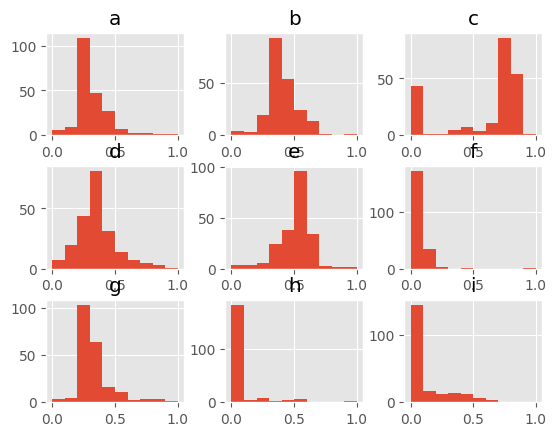

In [8]:
# Check the distribution of each additive using histogram
plt.style.use("ggplot")
scaled_data.hist()
plt.show()

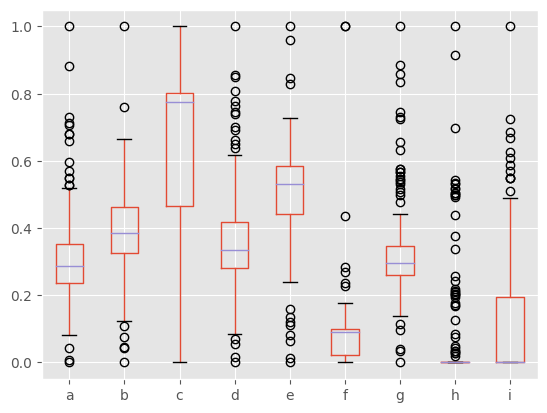

In [9]:
# Detect outliers using boxplot
scaled_data.boxplot()
plt.show()

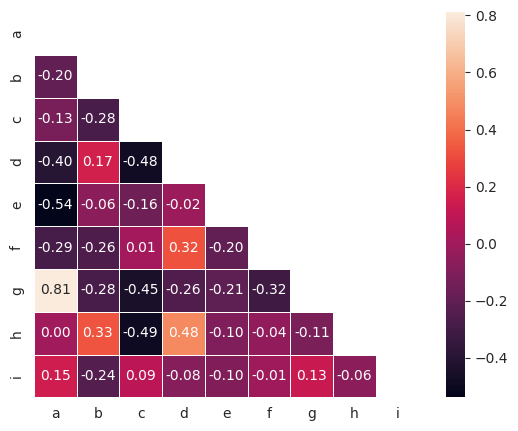

In [10]:
# Check correlation between additives using heatmap
corr = scaled_data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, square=True, annot=True, fmt=".2f", linewidths=.5)

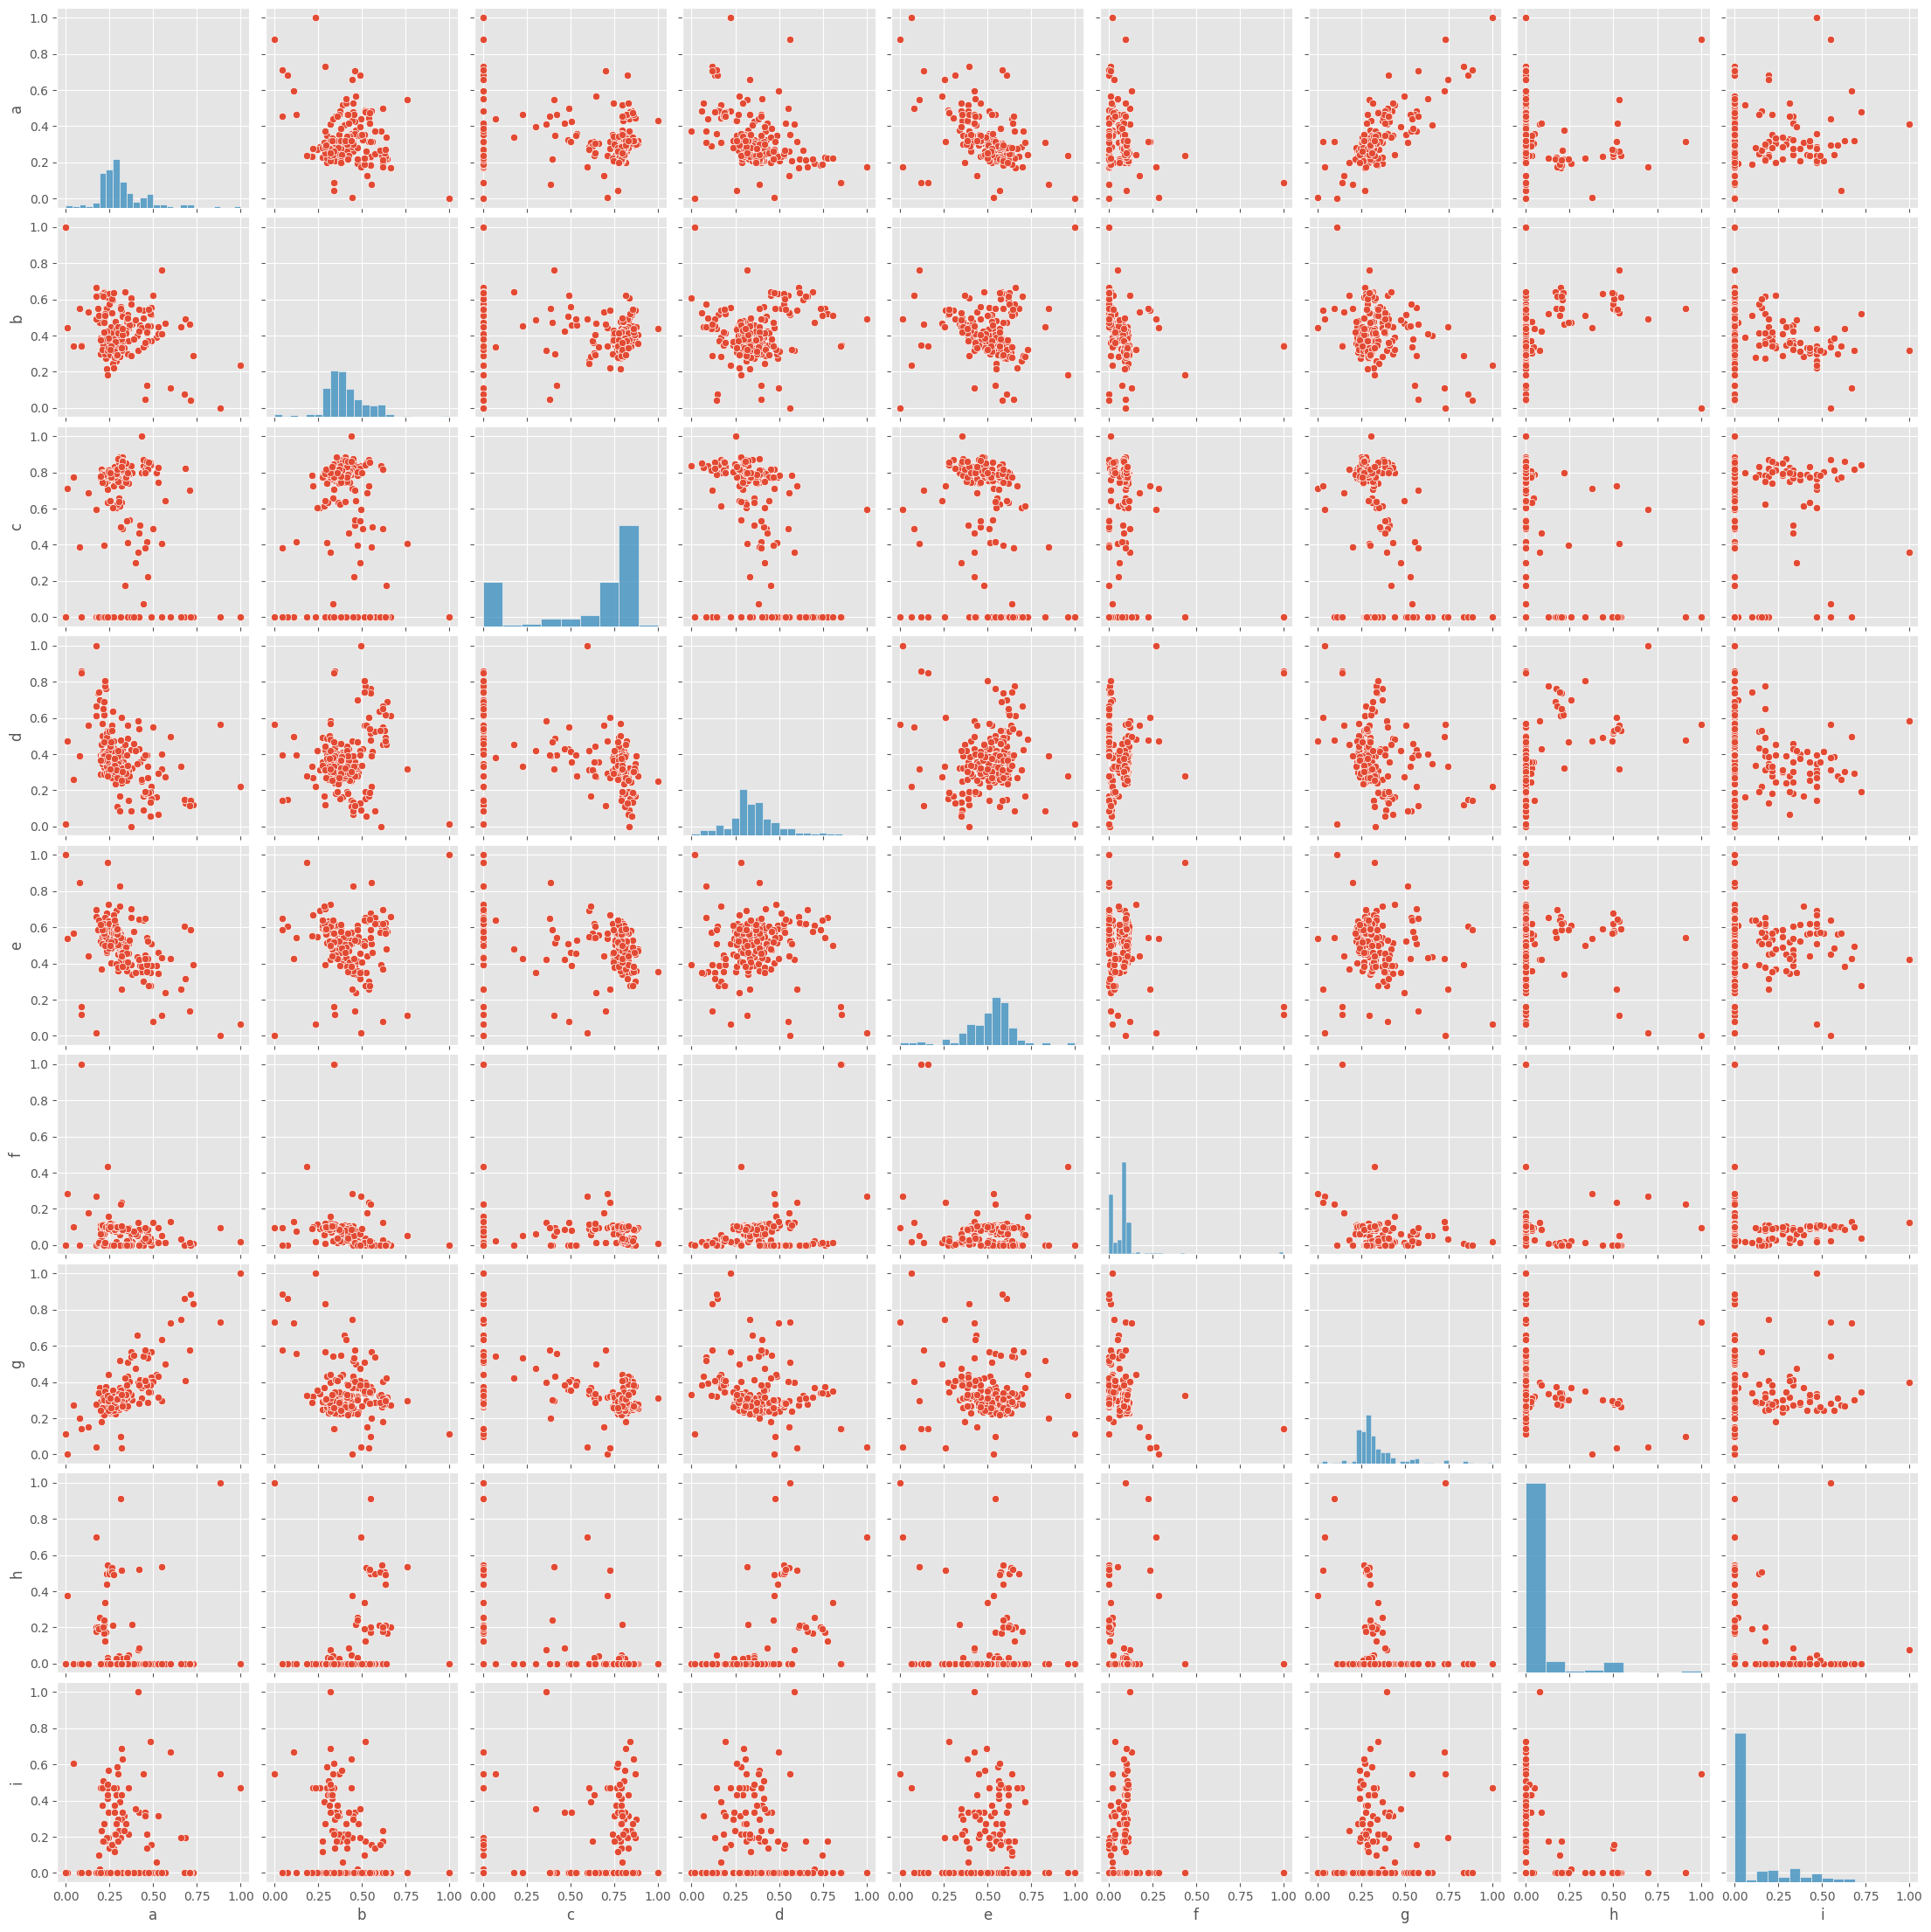

In [11]:
# Check the relationship between additives using scatterplotmatrix
sns.pairplot(scaled_data)
plt.show()

### Summary:
We normalized the data to have minimum of 0 and maximum of 1 using MinMaxScaler. Based on the histogram, we can see that additives a, b, d, e, g are roughly following normal distribution. Additive c has bimodal distribution whereas additives f, h, i are following right skewed distribution. According to the boxplots, we can see that all additives have outliers except additive c. We don't remove outliers because these are the trials conducted by the clients to obtain different formulation of petrol, so it's not a mistake or error. Based on the correlation heatmap and scatterplotmatrix, we can see that almost all additives have weak to moderate correlation with each other which is good because it means that there are no redundant attributes in the dataset, all attributes will contribute in different way to the formulation of petrol. However, we did see additives a and g have strong positive correlation meaning that these two attributes might convey the same meaning, either one can be removed from the analysis.

## D. KMeans Clustering

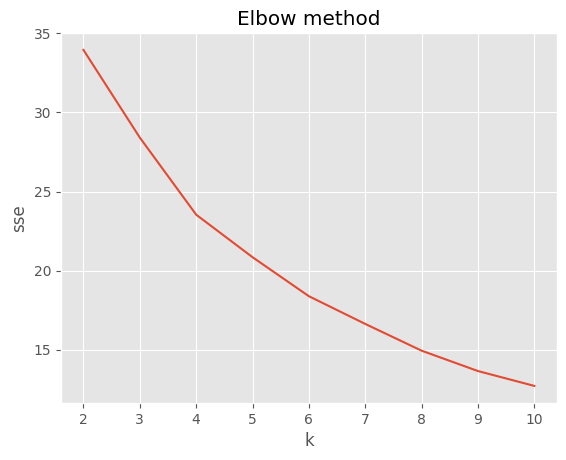

In [12]:
# Determine the best number of k using elbow methods
sse = defaultdict(list)
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    sse["k"].append(k)
    sse["sse"].append(kmeans.inertia_)
plt.plot(sse["k"], sse["sse"])
plt.title("Elbow method")
plt.xlabel("k")
plt.ylabel("sse")
plt.show()

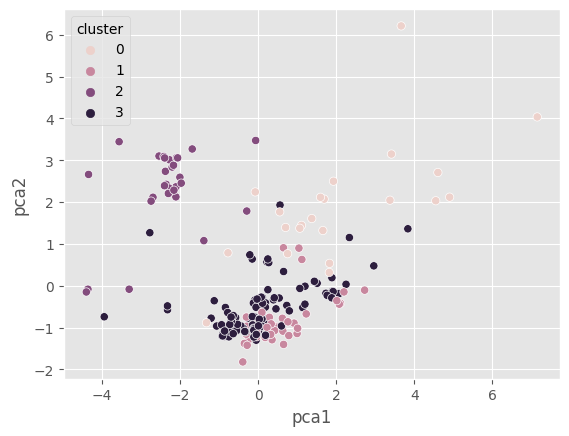

In [13]:
# Use k=4 and visualize the clusters on first two principal components using scatterplot
kmeans = KMeans(n_clusters=4, random_state=0).fit(scaled_data)
standard_scaler = StandardScaler().fit(data)
standardized_data = standard_scaler.transform(data)
pca = PCA(n_components=2, random_state=0).fit(standardized_data)
principal_components = pd.DataFrame(pca.transform(standardized_data), columns=["pca1", "pca2"])
principal_components["cluster"] = kmeans.labels_
sns.scatterplot(x="pca1", y="pca2", hue="cluster", data=principal_components)
plt.show()

In [14]:
# Check cluster centroids in original scale
data["cluster"] = kmeans.labels_
centroids = data.groupby("cluster")[data.columns[:-1]].mean()
centroids

,a,b,c,d,e,f,g,h,i
cluster,,,,,,,,,
0,1.522747,12.761818,0.285455,1.353182,72.681818,0.405909,12.159545,0.143182,0.068182
1,1.518171,13.090750,3.407250,1.276500,72.690750,0.512000,8.757500,0.025250,0.219000
2,1.516416,14.584828,0.243793,2.230690,72.865862,0.560345,8.409310,1.018621,0.013448
3,1.518071,13.341967,3.451066,1.337869,72.588443,0.496721,8.570000,0.030820,0.012705


### Summary:
We performed several KMeans clustering analysis using different number of k ranging from 2 to 10. Based on the elbow method, we identified k=4 is the optimal number of cluster for this dataset. We also get the first two principal components of the dataset using PCA, and visualize the clusters on a scatterplot. The scatterplot shows a clean split between each cluster. Therefore, we can say that there are 4 formulations exist in this dataset. The cluster centroids in original scale are shown in the table above.

## E. ANOVA

In [15]:
# Perform ANOVA test on each additive between four clusters
selected_columns = data.columns[:-1]
cluster0 = data.loc[data["cluster"]==0, selected_columns].values
cluster1 = data.loc[data["cluster"]==1, selected_columns].values
cluster2 = data.loc[data["cluster"]==2, selected_columns].values
cluster3 = data.loc[data["cluster"]==3, selected_columns].values
F, p = f_oneway(cluster0, cluster1, cluster2, cluster3)
anova = pd.DataFrame({"F-value":F, "p-value":p},index=selected_columns)
anova

,F-value,p-value
a,26.992124,8.514856e-15
b,42.923696,1.179522e-21
c,547.133744,1.158250e-98
d,45.572031,1.057594e-22
e,1.056255,3.687077e-01
f,0.237398,8.702175e-01
g,100.150712,3.260697e-40
h,58.827024,1.301065e-27
i,139.599831,1.147306e-49


### Summary:
After getting the number of clusters, we can perform ANOVA test between four formulations to verify if the formulations are significantly different at 95% significant level. The hypothesis is as follow:
- Null hypothesis: The formulations are the same.
- Alternative hypothesis: The formulations are different. (our claim)

After performing the ANOVA test, almost all additives have high F-value and p-value lower than 0.05 except additives e and f. Since p-value is lower than 0.05, we reject the null hypothesis, meaning that the mean of these additive levels in different formulations are statistically different. However, for additives e and f, since the p-value is higher than 0.05, we failed to reject the null hypothesis, meaning that the mean of additives e and f in different formulations are the same. This also indicates that the clients don't need to add additives e and f into the formulation of petrol because they won't affect the formulation at all. By combining all the ANOVA results, majority of the additives proved that the formulations are statistically different at significant level of 95%.